**Setup**

These are the same steps you'd take to download and start running this on your own machine.

To run Google Colab cells most easily, use `ctrl + enter`

In [0]:
!git clone -l -s git://github.com/gerardrbentley/unsupervised-game-segmentation.git game-segmentation
%cd game-segmentation
!ls

Cloning into 'game-segmentation'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 74 (delta 38), reused 73 (delta 37), pack-reused 0
Receiving objects: 100% (74/74), 13.38 MiB | 13.92 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/game-segmentation
crf.py		      input_target_transforms.py  README.md
datasets.py	      LICENSE			  requirements.txt
distributed_utils.py  loss.py			  saved_models
evaluation.py	      ml_args.py		  train.py
faim_tensorboard.py   models.py			  visualize.py
filters_2d.py	      overfit-icarus.png
__init__.py	      overfit.png


In [0]:
# Should all be satisfied in colab
!pip install -r requirements.txt

In [0]:
# Might take 30-60 seconds. Alternative: pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install pydensecrf

     |████████████████████████████████| 1.0MB 8.3MB/s 
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc3-cp36-cp36m-linux_x86_64.whl size=2153775 sha256=b94e2a136f50b96da12777e37e7ebc755065fe5d8765ea6c46cfbb5c72c0a3f3
  Stored in directory: /root/.cache/pip/wheels/92/6f/ec/5c49c25de8c42c872de50ff53582ba3ead850ce52a81e73ac7
Successfully built pydensecrf


# Running Some Code

We'll start by visualizing the image we want to segment, to make sure we have access to it and it looks right.

In google colab we can't use imshow normally, so we use %matplotlib inline to display

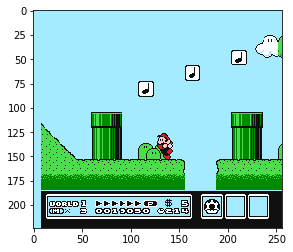

In [0]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
%matplotlib inline
testim = mpimg.imread('overfit.png')
plt.figure()
plt.imshow(testim)

# Loading Up a Neural Network Model

Here we initialize our model, put it on the gpu, and load the saved checkpoint

In [0]:
import torch
from models import WNet
my_model = WNet()

DEVICE = 'cpu'
if torch.cuda.is_available():
  print('Using GPU')
  DEVICE = 'cuda'
  my_model.to(DEVICE)
else:
  print('Not using GPU. In Colab go to Edit -> Notebook Settings for hardware acceleration')

checkpoint = torch.load('saved_models/mario_overfit.pth', map_location='cpu')
my_model.load_state_dict(checkpoint['model'])

Using GPU


<All keys matched successfully>

# Prepare the image as input to Model

Here we actually load the image as we will to feed it into the neural network. We use Python Pillow image library and torchvision transformations applied to the original image and a copy of it (which will be the goal / target of the neural network)

In [0]:
from PIL import Image
import input_target_transforms as TT

input_image = Image.open('overfit.png').convert('RGB')
# Our training is unsupervised, so our target is to reconstruct the original image
target_image = input_image.copy()

transformations = []
# To get an image ready as input to the model, it needs to be standard size
transformations.append(TT.Resize(224))
# It also should be a torch tensor instead of PIL Image
transformations.append(TT.ToTensor())
# Finally, we normalize the pixel values for training stability (these values are from real world images though)
transformations.append(TT.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
# This gives us a function that chains together the 3 transforms above ^
transform_inputs = TT.Compose(transformations)

# This runs the transform functions on our input and target so now they're both ready
input_image, target_image = transform_inputs(input_image, target_image)
# Well, actually we need to make sure they are on the same device (cpu or gpu) and batched for the model
input_image, target_image = input_image.to(DEVICE).unsqueeze(0), target_image.to(DEVICE).unsqueeze(0)
# Shape represents Batch, Channels, Height, and Width for PyTorch images
# We're expecting [1, 3, 224, 256]
target_image.shape

torch.Size([1, 3, 224, 256])

# Run the image through the model and get the output

This WNet implementation returns both an AutoEncoder Reconstruction and a Semantic Segmentation Map, so we'll visualize both.


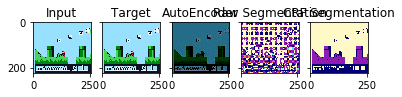

In [0]:
from visualize import visualize_outputs, argmax_to_rgb
from crf import crf_batch_fit_predict
# Gets the network's predictions about our image
output = my_model(input_image)
segmentation_mask, reconstruction = output['mask'], output['reconstruction']

# Do some visualizing and processing on semantic segmentation with Conditional Random Fields
np_mask = segmentation_mask.detach().cpu().numpy()
np_image = input_image.detach().cpu().numpy()
np_new_mask = crf_batch_fit_predict(np_mask, np_image)

# Return to pytorch and get highest predicted class at each pixel
mask_viz = segmentation_mask.to(DEVICE).argmax(1).float()
new_mask_viz = torch.from_numpy(np_new_mask).to(DEVICE).argmax(1).float()

# Color the segmentation images more iterestingly
mask_viz = argmax_to_rgb(mask_viz).unsqueeze(0)
new_mask_viz = argmax_to_rgb(new_mask_viz).unsqueeze(0)

visualize_outputs(input_image, target_image, reconstruction, mask_viz, new_mask_viz, titles=['Input', 'Target', 'AutoEncoder', 'Raw Segmentation', 'CRF Segmentation'])

torch.Size([1, 3, 224, 256])


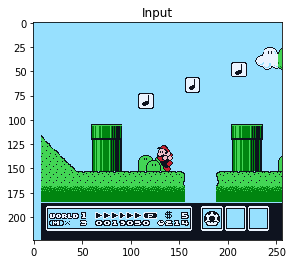

In [0]:
# Displayed One by One for closer view
visualize_outputs(input_image, titles=['Input'])

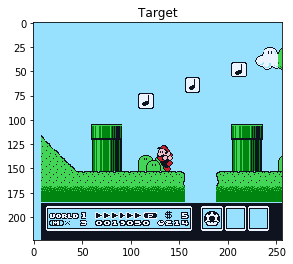

In [0]:
visualize_outputs(target_image, titles=['Target'])

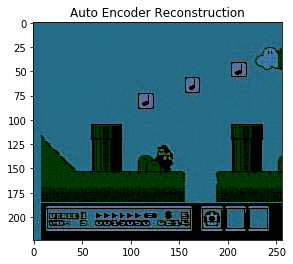

In [0]:
visualize_outputs(reconstruction, titles=['Auto Encoder Reconstruction'])

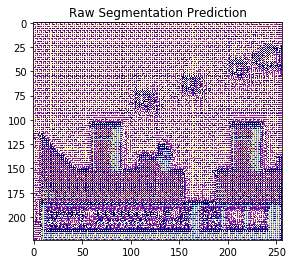

In [0]:
visualize_outputs(mask_viz, titles=['Raw Segmentation Prediction'])

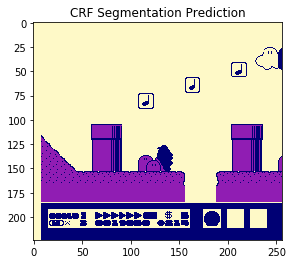

In [0]:
visualize_outputs(new_mask_viz, titles=['CRF Segmentation Prediction'])